# Imports and Paths

In [96]:
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

plotnine.options.figure_size = (12, 8)
from pandas.api.types import is_string_dtype
pd.options.display.max_columns=100
pd.options.display.max_rows=100

In [6]:
from fastai.imports import *
from fastai.structured import *

In [5]:
PATH = '/data/msnow/football/'

# Load and clean the data

In [4]:
df_games_raw = pd.read_feather(f'{PATH}df_games_raw.feather')
df_players_raw = pd.read_feather(f'{PATH}df_players_raw.feather')

In [10]:
df_games = df_games_raw.drop(columns=['age'])
df_players = df_players_raw.loc[:,['birth_date','height','player_id','position']]
df_players.birth_date = pd.to_datetime(df_players.birth_date, format='%Y-%m-%d')
df_players['birth_year'] = df_players.birth_date.dt.year

In [11]:
ht_tmp_ft = pd.to_numeric(df_players.height.str.split('-').str.get(0), errors='coerce') 
ht_tmp_in = pd.to_numeric(df_players.height.str.split('-').str.get(1), errors='coerce') 
ht_tmp = ht_tmp_ft*12 + ht_tmp_in
ht_tmp.fillna(ht_tmp.mean(),inplace=True)
ht_tmp = ht_tmp.astype(int)
df_players.height = ht_tmp

In [13]:
df_merge = df_games.merge(df_players, on='player_id', how='left')
df_merge['age'] = df_merge.year - df_merge.birth_year.astype(int)
df_merge.drop(columns=['birth_year'], inplace=True)

In [14]:
df_merge.head()

,date,defense_interception_touchdowns,defense_interception_yards,defense_interceptions,defense_sacks,defense_safeties,defense_tackle_assists,defense_tackles,field_goal_attempts,field_goal_makes,game_location,game_number,game_won,kick_return_attempts,kick_return_touchdowns,kick_return_yards,opponent,opponent_score,passing_attempts,passing_completions,passing_interceptions,passing_rating,passing_sacks,passing_sacks_yards_lost,passing_touchdowns,passing_yards,player_id,player_team_score,point_after_attemps,point_after_makes,punt_return_attempts,punt_return_touchdowns,punt_return_yards,punting_attempts,punting_blocked,punting_yards,receiving_receptions,receiving_targets,receiving_touchdowns,receiving_yards,rushing_attempts,rushing_touchdowns,rushing_yards,team,year,height,position,age
0,1990-09-09,0,0,0,0.0,0,0,0,0,0,A,1,False,0,0,0,CHI,17,0,0,0,0.0,0,0,0,0,1809,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SEA,1990,72,DB,23
1,1990-09-16,0,0,0,0.0,0,0,0,0,0,H,2,False,0,0,0,RAI,17,0,0,0,0.0,0,0,0,0,1809,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SEA,1990,72,DB,23
2,1990-09-23,0,0,0,0.0,0,0,0,0,0,A,3,False,0,0,0,DEN,34,0,0,0,0.0,0,0,0,0,1809,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SEA,1990,72,DB,23
3,1990-10-01,0,0,0,0.0,0,0,0,0,0,H,4,True,0,0,0,CIN,16,0,0,0,0.0,0,0,0,0,1809,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SEA,1990,72,DB,23
4,1990-10-07,0,0,0,0.0,0,0,0,0,0,A,5,True,0,0,0,NWE,20,0,0,0,0.0,0,0,0,0,1809,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SEA,1990,72,DB,23


# Calculate the scores

In [16]:
ff_passing = df_merge.passing_yards*0.04 + df_merge.passing_touchdowns*4 - df_merge.passing_interceptions*2
ff_rushing = df_merge.rushing_yards*0.1 + df_merge.rushing_touchdowns*6
ff_receiving = df_merge.receiving_yards*0.1 + df_merge.receiving_touchdowns*6
ff_misc = df_merge.kick_return_touchdowns*6 + df_merge.punt_return_touchdowns*6 
ff_kick = df_merge.point_after_makes*2 - df_merge.point_after_attemps + df_merge.field_goal_makes * 5 - df_merge.field_goal_attempts
df_merge['ff_score'] = ff_passing + ff_rushing + ff_receiving + ff_misc + ff_kick

# Create the dataframe with the yearly average scores

In [28]:
df_year = df_merge.copy()
df_year.drop(columns=['date','game_location','opponent'], inplace=True)
df_year = df_year.groupby(['player_id', 'year'], sort=False, as_index=False).mean()
df_year = df_year.merge(df_players[['player_id','position']], on='player_id', how='left')

In [33]:
df_srt = df_year[['player_id', 'year']].sort_values(['player_id', 'year'])
first_season = df_srt[['player_id','year']].groupby(['player_id'], sort=False).first().reset_index()
first_season.rename(columns={'year':'first_season'}, inplace=True)
df_year = df_year.merge(first_season,on=['player_id'], how='left')
df_year['season_number'] = df_year.year - df_year.first_season
df_year.drop(columns=['first_season'], inplace=True)

In [34]:
df_year.head()

,player_id,year,defense_interception_touchdowns,defense_interception_yards,defense_interceptions,defense_sacks,defense_safeties,defense_tackle_assists,defense_tackles,field_goal_attempts,field_goal_makes,game_number,game_won,kick_return_attempts,kick_return_touchdowns,kick_return_yards,opponent_score,passing_attempts,passing_completions,passing_interceptions,passing_rating,passing_sacks,passing_sacks_yards_lost,passing_touchdowns,passing_yards,player_team_score,point_after_attemps,point_after_makes,punt_return_attempts,punt_return_touchdowns,punt_return_yards,punting_attempts,punting_blocked,punting_yards,receiving_receptions,receiving_targets,receiving_touchdowns,receiving_yards,rushing_attempts,rushing_touchdowns,rushing_yards,height,age,ff_score,position,season_number
0,1809,1990,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,8.6,0.533333,0.0,0.0,0.0,18.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,23.0,0.0,DB,0
1,1809,1991,0.0,3.6875,0.187500,0.062500,0.0,0.0,0.0,0.0,0.0,8.5,0.437500,0.0,0.0,0.0,16.312500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,24.0,0.0,DB,1
2,1809,1992,0.0,4.6000,0.066667,0.233333,0.0,0.0,0.0,0.0,0.0,8.8,0.133333,0.0,0.0,0.0,19.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,25.0,0.0,DB,2
3,1809,1993,0.0,0.0000,0.125000,0.000000,0.0,0.0,0.0,0.0,0.0,8.5,0.375000,0.0,0.0,0.0,19.625000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,26.0,0.0,DB,3
4,1809,1994,0.0,1.6000,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,8.0,0.400000,0.0,0.0,0.0,19.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,27.0,0.0,DB,4


In [71]:
df_year['ff_score_n1'] = -999
df_year['ff_score_n2'] = -999
df_year['ff_score_n3'] = -999
df_year.loc[df_year.index[df_year.season_number>0],'ff_score_n1'] = df_year.loc[(df_year.index[df_year.season_number>0] - 1),'ff_score'].values
df_year.loc[df_year.index[df_year.season_number>1],'ff_score_n2'] = df_year.loc[(df_year.index[df_year.season_number>1] - 2),'ff_score'].values
df_year.loc[df_year.index[df_year.season_number>2],'ff_score_n3'] = df_year.loc[(df_year.index[df_year.season_number>2] - 3),'ff_score'].values

# Random Forest

## Convert categorical columns to integers and split off target variable

In [85]:
df_year_cat = df_year.copy()
train_cats(df_year_cat)
df_x, df_y, nas = proc_df(df_year_cat, 'ff_score')

## Split the data into training and testing

In [100]:
def split_train_val(df, trn_amount, keep_order=True):
    if 0 <= trn_amount <= 1:
        n_trn = int(len(df)*trn_amount)
    else:
        n_trn = trn_amount
    if not keep_order:
        df = df.sample(frac=1)
    df_train = df[:n_trn]
    df_valid = df[n_trn:]
    return [df_train, df_valid]

In [101]:
len(df_x), df_x.player_id.nunique()

(86332, 19151)

In [102]:
id_trn_ct = int(0.8 * df_x.player_id.nunique())
id_trn = np.random.RandomState(42).choice(df_x.player_id.unique(),id_trn_ct, replace=False)

In [108]:
df_x_trn.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            86317, 86318, 86319, 86320, 86321, 86322, 86323, 86324, 86325,
            86330],
           dtype='int64', length=69162)

In [121]:
df_year_cat.loc[df_year_cat.ff_score>0,:].head(10)

,player_id,year,defense_interception_touchdowns,defense_interception_yards,defense_interceptions,defense_sacks,defense_safeties,defense_tackle_assists,defense_tackles,field_goal_attempts,field_goal_makes,game_number,game_won,kick_return_attempts,kick_return_touchdowns,kick_return_yards,opponent_score,passing_attempts,passing_completions,passing_interceptions,passing_rating,passing_sacks,passing_sacks_yards_lost,passing_touchdowns,passing_yards,player_team_score,point_after_attemps,point_after_makes,punt_return_attempts,punt_return_touchdowns,punt_return_yards,punting_attempts,punting_blocked,punting_yards,receiving_receptions,receiving_targets,receiving_touchdowns,receiving_yards,rushing_attempts,rushing_touchdowns,rushing_yards,height,age,ff_score,position,season_number,ff_score_n1,ff_score_n2,ff_score_n3
23,18182,1971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.000000,0.333333,0.000000,0.0,0.000000,21.333333,9.333333,19.777778,1.444444,51.333333,0.0,0.0,0.555556,124.444444,14.888889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.666667,74.0,23.0,4.377778,QB,1,0.000000,-999.000000,-999.000000
24,18182,1972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.777778,0.333333,0.000000,0.0,0.000000,25.444444,7.222222,15.222222,1.000000,57.033333,0.0,0.0,0.333333,116.666667,24.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.666667,0.222222,1.666667,74.0,24.0,5.500000,QB,2,4.377778,0.000000,-999.000000
25,18182,1973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.200000,0.600000,0.000000,0.0,0.000000,23.800000,2.000000,5.400000,0.400000,68.780000,0.0,0.0,0.400000,38.800000,31.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.0,25.0,2.352000,QB,3,5.500000,4.377778,0.000000
26,18182,1974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.714286,0.428571,0.000000,0.0,0.000000,22.571429,5.857143,10.571429,1.000000,49.942857,0.0,0.0,0.714286,82.857143,17.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.714286,0.000000,-0.285714,74.0,26.0,4.142857,QB,4,2.352000,5.500000,4.377778
27,18182,1975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.818182,0.454545,0.000000,0.0,0.000000,19.636364,11.636364,21.181818,1.272727,65.609091,0.0,0.0,0.818182,142.000000,17.636364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.545455,0.000000,3.454545,74.0,27.0,6.752727,QB,5,4.142857,2.352000,5.500000
28,18182,1976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.500000,0.583333,0.000000,0.0,0.000000,14.666667,10.666667,22.500000,1.083333,69.050000,0.0,0.0,0.916667,160.916667,22.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.083333,0.000000,4.250000,74.0,28.0,8.361667,QB,6,6.752727,4.142857,2.352000
35,13379,1968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000000,0.000000,3.000000,0.0,72.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,24.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,17.000000,71.0,23.0,1.700000,RB,0,-999.000000,-999.000000,-999.000000
36,11755,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.000000,0.588235,0.235294,0.0,4.588235,19.588235,0.000000,0.058824,0.000000,2.329412,0.0,0.0,0.000000,0.000000,19.529412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.411765,0.588235,0.058824,2.588235,2.588235,0.058824,19.000000,70.0,23.0,2.864706,RB,0,-999.000000,-999.000000,-999.000000
37,11755,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.000000,0.562500,0.500000,0.0,9.562500,20.812500,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,23.625000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.125000,1.500000,0.000000,10.562500,6.625000,0.312500,26.312500,70.0,24.0,5.562500,RB,1,2.864706,-999.000000,-999.000000
38,11755,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.500000,0.375000,0.687500,0.0,13.062500,18.687500,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,17.687500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.687500,0.812500,0.000000,6.312500,2.875000,0.25000

In [124]:
df_x_trn = df_x.loc[df_x.player_id.isin(id_trn),:]
df_y_trn = df_y[df_x_trn.index]
df_x_val = df_x.loc[~df_x.player_id.isin(id_trn),:]
df_y_val = df_y[df_x_val.index]

In [148]:
def custom_RFscore(m, train_set, valid_set, score_func='rmse', use_oob=False):
    train_pred = m.predict(train_set)
    if score_func == 'rmse':
        score = np.sqrt(((train_pred-valid_set)**2).mean())
    elif score_func == 'mse':
        score = ((train_pred - valid_set) ** 2).mean()
    if use_oob and hasattr(m, 'oob_score_'):
        return score, m.oob_score_
    return score

def print_custom_RFscore(df_x_trn, df_y_trn, df_x_val, df_y_val):
    train_rmse = custom_RFscore(m, df_x_trn, df_y_trn)
    valid_rmse = custom_RFscore(m, df_x_val, df_y_val) 
    train_score = m.score(df_x_trn, df_y_trn)
    valid_score = m.score(df_x_val, df_y_val)
    print(f'Training rmse: {train_rmse}')
    print(f'Validation rmse: {valid_rmse}')
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {valid_score}')
    if hasattr(m, 'oob_score_'):
        print(f'OOB Score: {m.oob_score_}')

In [149]:
m = RandomForestRegressor(n_estimators=30, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(df_x_trn, df_y_trn)
print_custom_RFscore(df_x_trn, df_y_trn, df_x_val, df_y_val)

Training rmse: 0.11262057182103008
Validation rmse: 0.27449739090051034
Training Score: 0.9988637934946156
Validation Score: 0.993685039521444
OOB Score: 0.9916882216570798


## Feature Importance

In [144]:
fi = rf_feat_importance(m, df_x_trn); fi[:10]

,cols,imp
45,ff_score_n1,0.290402
37,receiving_yards,0.113961
46,ff_score_n2,0.100975
40,rushing_yards,0.086442
34,receiving_receptions,0.072168
24,passing_yards,0.069772
23,passing_touchdowns,0.056194
38,rushing_attempts,0.053312
39,rushing_touchdowns,0.052462
36,receiving_touchdowns,0.023817


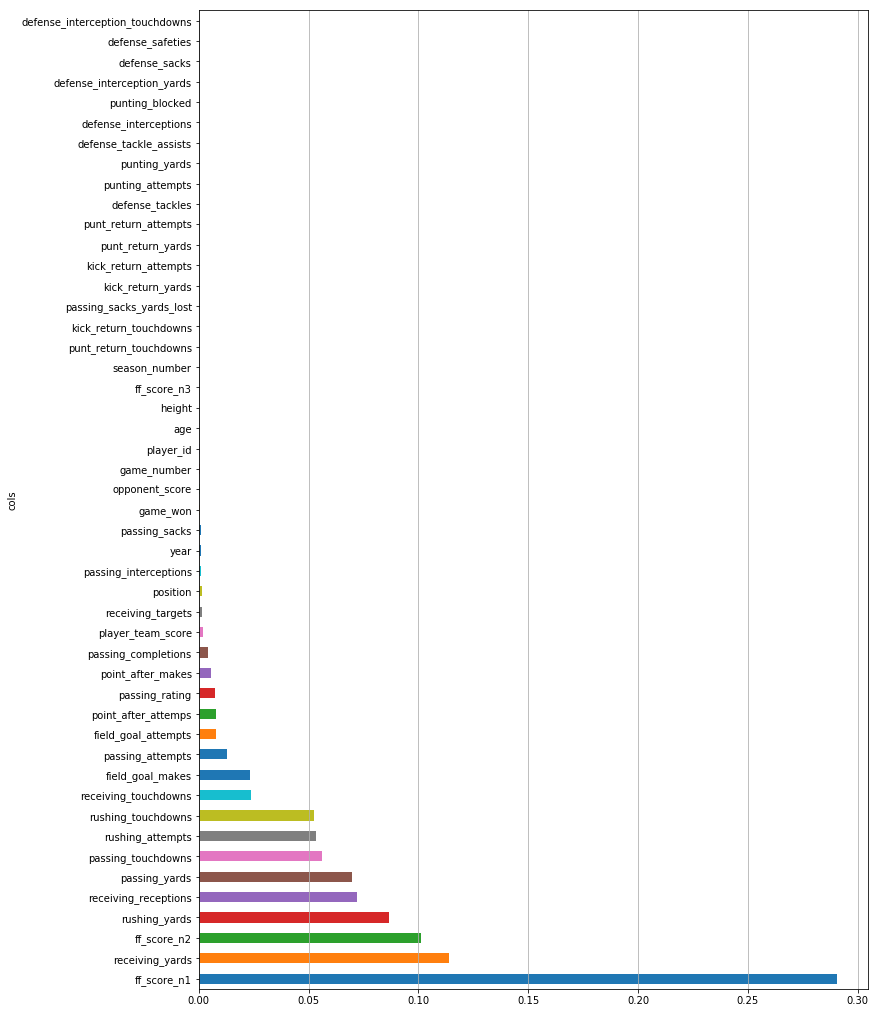

In [145]:
ax = fi.plot('cols', 'imp', 'barh', figsize=(12,18), legend=False, grid=True);
ax.yaxis.grid(False)

In [146]:
top_ft = fi[fi.imp>0.005].cols;
df_x_trn_top_ft = df_x_trn[top_ft]
df_x_val_top_ft = df_x_val[top_ft]

In [150]:
m = RandomForestRegressor(n_estimators=30, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(df_x_trn_top_ft, df_y_trn)
print_custom_RFscore(df_x_trn_top_ft, df_y_trn, df_x_val_top_ft, df_y_val)

Training rmse: 0.1263267548474387
Validation rmse: 0.2870964919799478
Training Score: 0.9985704067297644
Validation Score: 0.9930920375679193
OOB Score: 0.991222790566942


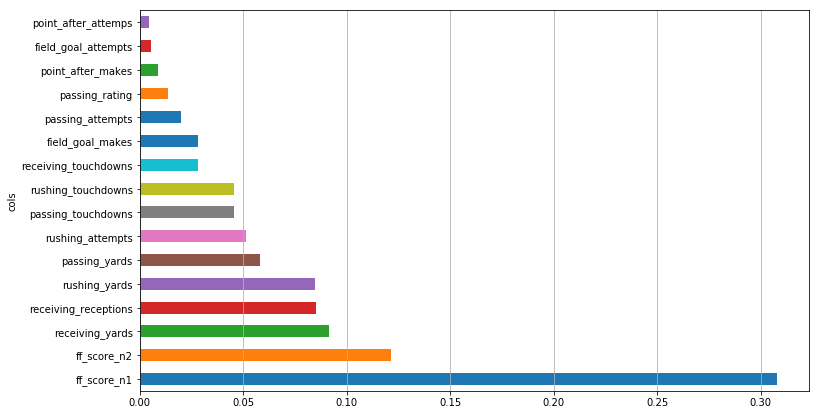

In [152]:
fi = rf_feat_importance(m, df_x_trn_top_ft)
ax = fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, grid=True);
ax.yaxis.grid(False)

In [164]:
df_x_tst = df_year.copy()
df_x_tst = df_x_tst.loc[df_x_tst.year==2017,:]
df_x_tst.ff_score_n3 = df_x_tst.ff_score_n2
df_x_tst.ff_score_n2 = df_x_tst.ff_score_n1
df_x_tst.ff_score_n1 = df_x_tst.ff_score
top_ft_pos = list(top_ft) + ['position']
df_x_tst = df_x_tst[top_ft_pos]

In [165]:
df_x_tst.head()

,ff_score_n1,receiving_yards,ff_score_n2,rushing_yards,receiving_receptions,passing_yards,passing_touchdowns,rushing_attempts,rushing_touchdowns,receiving_touchdowns,field_goal_makes,passing_attempts,field_goal_attempts,point_after_attemps,passing_rating,point_after_makes,position
21,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,ILB
34,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,ILB
60,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,DE
150,6.444444,51.111111,8.3500,0.0,4.111111,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,WR
211,7.320000,15.800000,8.8125,45.4,2.000000,0.0,0.0,10.2,0.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,RB


In [187]:
df_x_tst_qb = df_x_tst.loc[df_x_tst.position=='QB',:].copy()
df_x_tst_qb.drop(columns='position',inplace=True)
predict_ff = m.predict(df_x_tst_qb)
df_predict_qb = pd.DataFrame({'player_id':df_year.loc[df_x_tst_qb.index,'player_id'].values,'prediction':predict_ff})
df_predict_qb = df_predict_qb.merge(df_players_raw[['player_id','name']], on='player_id', how='left')
df_predict_qb.sort_values('prediction', ascending=False).reset_index()

,index,player_id,prediction,name
0,22,2240,21.647070,Tom Brady
1,24,23623,21.555527,Carson Wentz
2,47,23402,21.030861,Deshaun Watson
3,6,24421,20.426173,Russell Wilson
4,34,20509,19.570091,Alex Smith
5,49,4644,19.404533,Kirk Cousins
6,4,7476,18.978961,Blaine Gabbert
7,60,16363,18.691096,Cam Newton
8,21,21069,17.907130,Matthew Stafford
9,53,2328,16.987841,Drew Brees


In [189]:
df_players_raw.columns

Index(['birth_date', 'birth_place', 'college', 'current_salary',
       'current_team', 'death_date', 'draft_position', 'draft_round',
       'draft_team', 'draft_year', 'height', 'high_school',
       'hof_induction_year', 'name', 'player_id', 'position', 'weight'],
      dtype='object')

In [193]:
df_x_tst_all = df_x_tst.copy()
df_x_tst_all.drop(columns='position',inplace=True)
predict_ff = m.predict(df_x_tst_all)
df_predict_all = pd.DataFrame({'player_id':df_year.loc[df_x_tst_all.index,'player_id'].values,'prediction':predict_ff})
df_predict_all = df_predict_all.merge(df_players_raw[['player_id','name','position']], on='player_id', how='left')
df_predict_all = df_predict_all.sort_values('prediction', ascending=False).reset_index(drop=True)
df_predict_all

,player_id,prediction,name,position
0,2240,21.647070,Tom Brady,QB
1,23623,21.555527,Carson Wentz,QB
2,23402,21.030861,Deshaun Watson,QB
3,24421,20.426173,Russell Wilson,QB
4,20509,19.570091,Alex Smith,QB
5,4644,19.404533,Kirk Cousins,QB
6,6375,19.260575,Ezekiel Elliott,RB
7,7476,18.978961,Blaine Gabbert,QB
8,16363,18.691096,Cam Newton,QB
9,21069,17.907130,Matthew Stafford,QB


In [201]:
df_predict_all.loc[df_predict_all.position=='QB',:].reset_index()

,index,player_id,prediction,name,position
0,0,2240,21.647070,Tom Brady,QB
1,1,23623,21.555527,Carson Wentz,QB
2,2,23402,21.030861,Deshaun Watson,QB
3,3,24421,20.426173,Russell Wilson,QB
4,4,20509,19.570091,Alex Smith,QB
5,5,4644,19.404533,Kirk Cousins,QB
6,7,7476,18.978961,Blaine Gabbert,QB
7,8,16363,18.691096,Cam Newton,QB
8,9,21069,17.907130,Matthew Stafford,QB
9,11,2328,16.987841,Drew Brees,QB


In [202]:
df_predict_all.loc[df_predict_all.position=='RB',:].reset_index()

,index,player_id,prediction,name,position
0,6,6375,19.260575,Ezekiel Elliott,RB
1,10,8657,17.886231,Todd Gurley,RB
2,19,1465,15.496925,Le'Veon Bell,RB
3,24,7203,14.815061,Leonard Fournette,RB
4,27,11877,14.599068,Alvin Kamara,RB
5,30,4458,14.325082,Dalvin Cook,RB
6,32,10635,14.202289,Mark Ingram,RB
7,33,10496,14.110493,Kareem Hunt,RB
8,36,8145,13.509001,Melvin Gordon,RB
9,44,14591,12.221571,LeSean McCoy,RB


In [203]:
df_predict_all.loc[df_predict_all.position=='WR',:].reset_index()

,index,player_id,prediction,name,position
0,21,2544,15.053892,Antonio Brown,WR
1,34,10191,13.812863,DeAndre Hopkins,WR
2,43,1383,12.258723,Odell Beckham Jr.,WR
3,52,11634,11.348255,Julio Jones,WR
4,56,7450,11.125509,Will Fuller,WR
5,59,21992,11.025573,Adam Thielen,WR
6,61,11662,10.946464,Marvin Jones,WR
7,65,317,10.824698,Keenan Allen,WR
8,67,4480,10.804284,Brandin Cooks,WR
9,69,8337,10.746712,A.J. Green,WR


In [204]:
df_predict_all.loc[df_predict_all.position=='TE',:].reset_index()

,index,player_id,prediction,name,position
0,54,8573,11.204882,Rob Gronkowski,TE
1,73,6520,10.282726,Zach Ertz,TE
2,83,12018,9.750640,Travis Kelce,TE
3,104,8220,8.605601,Jimmy Graham,TE
4,161,6484,7.031140,Evan Engram,TE
5,163,5925,6.892672,Jack Doyle,TE
6,170,19223,6.589375,Kyle Rudolph,TE
7,173,23085,6.546448,Delanie Walker,TE
8,181,2288,6.257427,Cameron Brate,TE
9,191,4032,5.957545,Charles Clay,TE


In [205]:
df_predict_all.loc[df_predict_all.position=='K',:].reset_index()

,index,player_id,prediction,name,position
0,39,21508,13.101818,Caleb Sturgis,K
1,41,25034,12.638601,Greg Zuerlein,K
2,45,3132,12.106558,Harrison Butker,K
3,48,8172,11.546370,Stephen Gostkowski,K
4,51,13722,11.349799,Wil Lutz,K
5,58,7114,11.094304,Kai Forbath,K
6,62,17895,10.935182,Matt Prater,K
7,63,21521,10.897441,Ryan Succop,K
8,68,2069,10.774562,Chris Boswell,K
9,71,22951,10.425737,Adam Vinatieri,K


# Teams

In [209]:
df_teams_avg = pd.read_feather(f'{PATH}df_teams_avg.feather')

In [211]:
df_teams_avg.shape

(1476, 36)

In [212]:
df_teams_avg.dtypes

team               object
Year                int64
blocked_fg_td     float64
def_int           float64
first_down_def    float64
first_down_off    float64
fumbles_rec       float64
fumbles_rec_td    float64
int_td            float64
kick_ret_td       float64
pass_yds_def      float64
pass_yds_off      float64
pts_def           float64
pts_off           float64
punt_blocked      float64
punt_ret_td       float64
rush_yds_def      float64
rush_yds_off      float64
sacks             float64
safety_md         float64
to_def            float64
to_off            float64
yards_def         float64
yards_off         float64
pa_00             float64
pa_01_06          float64
pa_07_13          float64
pa_14_21          float64
pa_28_34          float64
pa_inf            float64
ff_score          float64
season_number       int64
ff_n1             float64
ff_n2             float64
ff_n3             float64
ff_n4             float64
dtype: object

In [213]:
df_teams = df_teams_avg.copy()
train_cats(df_teams)
df_x, df_y, nas = proc_df(df_teams, 'ff_score')